In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    %cd gdrive/My Drive/COMP6248/COMP6248-Reproducibility-Challenge/implementation
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/COMP6248/COMP6248-Reproducibility-Challenge/implementation


In [2]:
try:
    import tslearn
except:
    !pip install tslearn

     |████████████████████████████████| 747kB 12.1MB/s 


In [0]:
import numpy as np
import torch
from data.synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(0)

# parameters
batch_size = 100
N = 500
N_input = 20
N_output = 20  
sigma = 0.01
gamma = 0.01

In [0]:
# Load synthetic dataset
X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

In [0]:
def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=10,eval_every=10, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)             
                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 

In [7]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  1.5201679468154907  loss shape  2.85638427734375  loss temporal  0.18395161628723145
 Eval mse=  0.1514204353094101  dtw=  1.439509807712358  tdi=  0.14555
epoch  50  loss  0.6341617107391357  loss shape  0.8567941188812256  loss temporal  0.4115292727947235
 Eval mse=  0.04765921756625176  dtw=  0.7905504902635372  tdi=  0.73142
epoch  100  loss  0.4381508529186249  loss shape  0.5444338917732239  loss temporal  0.3318678140640259
 Eval mse=  0.03855564445257187  dtw=  0.68227758450879  tdi=  0.8553199999999999
epoch  150  loss  0.46081918478012085  loss shape  0.5917860865592957  loss temporal  0.32985225319862366
 Eval mse=  0.02975064665079117  dtw=  0.5876146715544046  tdi=  0.666755
epoch  200  loss  0.25847646594047546  loss shape  0.23834358155727386  loss temporal  0.27860933542251587
 Eval mse=  0.022940759733319282  dtw=  0.5048106394555055  tdi=  0.85838
epoch  250  loss  0.19789674878120422  loss shape  0.05262850597500801  loss temporal  0.3431649804115295

In [8]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch  0  loss  0.13935846090316772  loss shape  0  loss temporal  0
 Eval mse=  0.1302681416273117  dtw=  1.303727054227379  tdi=  0.5196149999999999
epoch  50  loss  0.041497353464365005  loss shape  0  loss temporal  0
 Eval mse=  0.0329080656170845  dtw=  0.6309580528040175  tdi=  2.10686
epoch  100  loss  0.018663739785552025  loss shape  0  loss temporal  0
 Eval mse=  0.02134897783398628  dtw=  0.47804181444014293  tdi=  2.1516450000000007
epoch  150  loss  0.01531547587364912  loss shape  0  loss temporal  0
 Eval mse=  0.013912992551922798  dtw=  0.35939723959267805  tdi=  1.85716
epoch  200  loss  0.0069893235340714455  loss shape  0  loss temporal  0
 Eval mse=  0.0119435278698802  dtw=  0.2980012095025546  tdi=  1.79193
epoch  250  loss  0.008411523886024952  loss shape  0  loss temporal  0
 Eval mse=  0.009764097817242145  dtw=  0.26430765643883924  tdi=  1.7457800000000003
epoch  300  loss  0.007670119404792786  loss shape  0  loss temporal  0
 Eval mse=  0.00982719827443

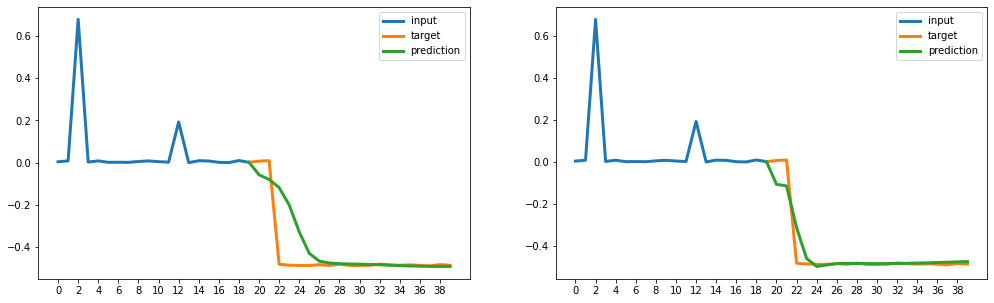

In [28]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate]

for ind in range(15,16):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,2,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,40,2))
        plt.legend()
        k = k+1
    plt.savefig('mse_dilate_1.pdf', bbox_inches='tight')

## Saving Model

### Saving State Dict

In [0]:
torch.save(net_gru_dilate.state_dict(), 'dilate_state_dict')
torch.save(net_gru_mse.state_dict(), 'mse_state_dict')

In [0]:
torch.save(net_gru_dilate, 'dilate_model')
torch.save(net_gru_mse, 'mse_model')